In [1]:
#import torch
import pandas as pd
import numpy as np
import json
import os
import sys
from sklearn.metrics import f1_score
import h3pandas
import torch
import h3
from sklearn.metrics import precision_recall_curve
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt

#sys.path.append('../')
import datasets
import models
import utils
import setup

/var/folders/pp/c6m9_85s5rd16hbzmflk4b9r0000gn/T/ipykernel_85030/1400829063.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/filipdorm/opt/anaconda3/envs/sinr_icml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


get training data

In [2]:
train_params = {}

train_params['experiment_name'] = 'demo' # This will be the name of the directory where results for this run are saved.
train_params['species_set'] = 'all'
train_params['hard_cap_num_per_class'] = 1000
train_params['num_aux_species'] = 0
train_params['input_enc'] = 'sin_cos'
train_params['loss'] = 'an_full'

In [3]:
params = setup.get_default_params_train(train_params)

In [4]:
train_dataset = datasets.get_train_data(params)


Loading  data/train/geo_prior_train.csv
Number of unique classes 47375
subsampling (up to) 1000 per class for the training set
final training set size: 15132683


In [5]:
train_df = pd.DataFrame(train_dataset.locs, columns=['lng','lat'])
train_df['lng'] = train_df['lng']*180
train_df['lat'] = train_df['lat']*90
train_df['label'] = train_dataset.labels

In [6]:
train_df = train_df#[:100000]

In [7]:
h3_resolution = 4
train_df_h3 = train_df.h3.geo_to_h3(h3_resolution)
all_spatial_grid_counts = train_df_h3.index.value_counts()
presence_absence = pd.DataFrame({
    "background": all_spatial_grid_counts,
})
presence_absence = presence_absence.fillna(0)

In [8]:
resolution = h3_resolution
area = h3.hex_area(resolution)

In [9]:
# load model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_params = torch.load('./pretrained_models/model_an_full_input_enc_sin_cos_hard_cap_num_per_class_1000.pt', map_location='cpu')
model = models.get_model(train_params['params'])
model.load_state_dict(train_params['state_dict'], strict=True)
model = model.to(DEVICE)
model.eval()

ResidualFCNet(
  (class_emb): Linear(in_features=256, out_features=47375, bias=False)
  (feats): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=

In [10]:
if train_params['params']['input_enc'] in ['env', 'sin_cos_env']:
    raster = datasets.load_env()
else:
    raster = None
enc = utils.CoordEncoder(train_params['params']['input_enc'], raster=raster)

In [11]:
#load reference from iucn
with open(os.path.join('./data/eval/iucn/', 'iucn_res_5.json'), 'r') as f:
            data = json.load(f)
species_ids = list((data['taxa_presence'].keys()))

In [12]:
def generate_h3_cells_atRes(resolution=4):
    h3_cells = list(h3.get_res0_indexes())
    h3_atRes_cells = set()
    for cell in h3_cells:
        h3_atRes_cells = h3_atRes_cells.union(h3.h3_to_children(cell, resolution))
    return list(h3_atRes_cells)

In [13]:
#generate gdfk table
h3_atRes_cells = generate_h3_cells_atRes(h3_resolution)
gdfk = pd.DataFrame(index=h3_atRes_cells).h3.h3_to_geo()
gdfk["lng"] = gdfk["geometry"].x
gdfk["lat"] = gdfk["geometry"].y
_ = gdfk.pop("geometry")
gdfk = gdfk.rename_axis('h3index')


In [14]:
obs_locs = np.array(gdfk[['lng', 'lat']].values, dtype=np.float32)
obs_locs = torch.from_numpy(obs_locs).to('cpu')
loc_feat = enc.encode(obs_locs)

In [15]:
classes_of_interest = torch.zeros(len(species_ids), dtype=torch.int64)
taxa_ids = torch.zeros(len(species_ids), dtype=torch.int64)
for tt_id, tt in enumerate(species_ids):
    class_of_interest = np.array([train_params['params']['class_to_taxa'].index(int(tt))])
    classes_of_interest[tt_id] = torch.from_numpy(class_of_interest)
    

In [16]:
with torch.no_grad():
    loc_emb = model(loc_feat, return_feats=True)
    wt = model.class_emb.weight[classes_of_interest, :]

In [17]:
output = []
for class_index, class_id in enumerate(classes_of_interest):
    wt_1 = wt[class_index,:]
    preds = torch.sigmoid(torch.matmul(loc_emb, wt_1)).cpu().numpy()
    gdfk["pred"] = preds

    target_spatial_grid_counts = train_df_h3[train_df_h3.label==class_id.item()].index.value_counts()
         
    presence_absence["forground"] = target_spatial_grid_counts
    presence_absence["predictions"] = gdfk["pred"]
    presence_absence.forground = presence_absence.forground.fillna(0)

    presences = presence_absence[(presence_absence["forground"]>0)]["predictions"]

    #thres = presences.min()
    thres = np.percentile(presences, 10)
    
    row = {
        "taxon_id": train_dataset.class_to_taxa[class_id.item()],
        "thres": thres,
    }
    row_dict = dict(row)
    output.append(row_dict)

    if(class_index%100==0):
            print(class_index)
    #if class_index == 2: break

output_pd = pd.DataFrame(output)
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


/var/folders/pp/c6m9_85s5rd16hbzmflk4b9r0000gn/T/ipykernel_85030/862584146.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


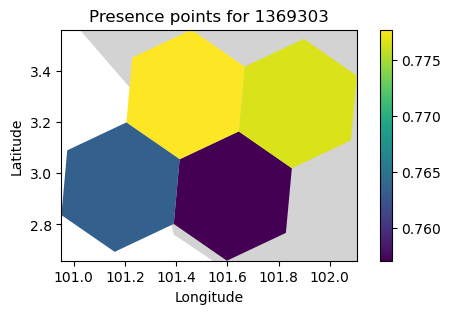

In [18]:
def add_geometry(h3_cell):
  points = h3.h3_to_geo_boundary(h3_cell, True)
  return Polygon(points)

df = pd.DataFrame(presences).reset_index()
df['geometry'] = df.h3_04.apply(lambda a : add_geometry(a))
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=df['geometry'])
minx, miny, maxx, maxy = gdf.total_bounds

fig, ax = plt.subplots(figsize=(6,3))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))

countries.plot(color="lightgray", ax=ax)

gdf.plot(column='predictions', cmap='viridis', ax=ax, legend=True)

ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

plt.title(f"Presence points for {train_dataset.class_to_taxa[class_id.item()]}")

plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

In [19]:
output_pd.to_csv("./results/thresholds/thres_masking_90.csv")

In [20]:
output_pd.thres.mean()

0.3657241164122645